In [1]:
import warnings
warnings.filterwarnings("ignore")

In [159]:
import pandas as pd
evadidos1 = pd.read_csv('graduacao_evadidos.csv',sep=';', encoding='latin-1')
evadidos19_1 = pd.read_csv('evadidos19_1.csv',sep=';', encoding='latin-1')
evadidos18_2 = pd.read_csv('evadidos18_2.csv',sep=';', encoding='latin-1')
evadidos18_1 = pd.read_csv('evadidos18_1.csv',sep=';', encoding='latin-1')

#Unir os ultimos 3 periodos em um dataframe, todos tinham cabeçalho identico
evadidos_EM_novo = pd.concat([evadidos18_1, evadidos18_2, evadidos19_1], ignore_index=False, sort = False)

#Transformo a cabeçalho de todas as colunas em letra maiuscula e sem acento. 
evadidos1.columns = evadidos1.columns.str.upper()
evadidos_EM_novo.columns = evadidos1.columns.str.upper()

#selecionando a Escola de Minas
evadidos1em = evadidos1.loc[evadidos1['UNIDADE_ACADEMICA'] == 'ESCOLA DE MINAS']
evadidos_EM_novo = evadidos_EM_novo.loc[evadidos_EM_novo['UNIDADE_ACADEMICA'] == 'ESCOLA DE MINAS']

#juntando o dataframe com todos os evadidos da EM
evadidos = pd.concat([evadidos_EM_novo, evadidos1em], ignore_index=False, sort = False)

In [160]:
#Tabela base para a formulação dos gráficos e análises.
evadidos_por_data_curso_ano = evadidos.groupby([ 'ANO', 'CURSO', 'TIPO_EVASAO']).EVADIDOS.sum().to_frame(name = 'Evadidos').reset_index()

<h4>Problemas:</h4>

- Fazer a taxa de evasão com os matriculados de cada curso de cada ano. (check)

- Gerar os valores nulos nos Evadidos quando o tipo de evasão não tiver ocorrido no ano. (check)

- Concatenar todos os cursos. (check)

In [161]:
#seleção dos bancos de dados de matriculados
EM_total = pd.read_csv('emtotalordenado.csv',sep=';', encoding='latin-1')
EM_total.columns
EM_total['SemestreLetivo'] = pd.to_datetime(EM_total['SemestreLetivo'], format='%Y/%m').dt.year

matriculados = EM_total.groupby(['SemestreLetivo','Curso']).TotalGeral.sum()
matriculados = pd.DataFrame(matriculados).reset_index()
matriculados

#Criação da tabela com taxa de letalidade
tabela = pd.DataFrame(evadidos_por_data_curso_ano)
tabela = tabela.merge(matriculados, left_on=['ANO','CURSO'], right_on= ['SemestreLetivo','Curso'])
tabela = tabela.drop(columns= ['Curso'])

tabela = tabela.drop(columns= ['SemestreLetivo'])
tabela['Taxa evasao'] = (tabela['Evadidos']/tabela['TotalGeral'])*100

In [162]:
tipos_evasao = pd.DataFrame(evadidos['TIPO_EVASAO'].unique())
tipos_evasao = tipos_evasao.rename(columns={list(tipos_evasao)[0]: 'Tipo de evasao'})

cursos = pd.DataFrame(evadidos['CURSO'].unique())
cursos = cursos.rename(columns={list(cursos)[0]: 'CURSOS'})

ANOS = pd.DataFrame(evadidos['ANO'].unique())
ANOS = ANOS.rename(columns={list(ANOS)[0]: 'ANO'})

In [163]:
todos_motivos = pd.Series(['TODOS SOMADOS'])
todos_motivos = pd.DataFrame(todos_motivos)
todos_motivos = todos_motivos.rename(columns={list(todos_motivos)[0]: 'Tipo de evasao'})

tipos_evasao = pd.concat([tipos_evasao, todos_motivos], ignore_index=True)

In [164]:
import itertools
um = pd.DataFrame(list(itertools.product(cursos['CURSOS'],tipos_evasao['Tipo de evasao'])), columns=['curso', 'motivo'])
dois = pd.DataFrame(list(itertools.product(cursos['CURSOS'],ANOS['ANO'])), columns=['curso', 'ano'])
base = um.merge(dois, left_on = 'curso', right_on = 'curso')

In [166]:
#merge base com dados
tabela = tabela.merge(base,how='right', left_on = ['ANO','CURSO','TIPO_EVASAO'], right_on = ['ano', 'curso', 'motivo'])
tabela = tabela.drop(columns= ['CURSO','TIPO_EVASAO','ANO'])
tabela = tabela.fillna(0)
tabela['curso']= tabela["curso"].str.split("-", n = 1, expand = True) 
#tabela = tabela.drop(columns= ['CURSO','TIPO_EVASAO','ANO'])
tabela = tabela[tabela.curso != 'ENGENHARIA URBANA']

,Evadidos,TotalGeral,Taxa evasao,curso,motivo,ano
0,1.0,217.0,0.460829,ENGENHARIA AMBIENTAL,CANCELAMENTO,2003
1,1.0,217.0,0.460829,ENGENHARIA AMBIENTAL,DESLIGAMENTO,2003
2,4.0,578.0,0.692042,ENGENHARIA CIVIL,DESLIGAMENTO,2003
3,6.0,578.0,1.038062,ENGENHARIA CIVIL,TRANSFERENCIA,2003
4,4.0,196.0,2.040816,ENGENHARIA DE CONTROLE E AUTOMACAO,CANCELAMENTO,2003
...,...,...,...,...,...,...
1377,0.0,0.0,0.000000,ENGENHARIA METALURGICA,TODOS SOMADOS,2013
1378,0.0,0.0,0.000000,ENGENHARIA METALURGICA,TODOS SOMADOS,2014
1379,0.0,0.0,0.000000,ENGENHARIA METALURGICA,TODOS SOMADOS,2015
1380,0.0,0.0,0.000000,ENGENHARIA METALURGICA,TODOS SOMADOS,2016


In [167]:
Tabela_ano_curso = evadidos.groupby(['CURSO', 'ANO']).EVADIDOS.sum().to_frame(name = 'Evadidos').reset_index()
Tabela_ano_curso['CURSO']= Tabela_ano_curso["CURSO"].str.split("-", n = 1, expand = True)

In [168]:
Tabela_ano_curso['motivo'] = 'TODOS SOMADOS'
matriculados['Curso']= matriculados["Curso"].str.split("-", n = 1, expand = True) 
Tabela_ano_curso = Tabela_ano_curso.merge(matriculados,how='left', left_on = ['ANO','CURSO'], right_on = ['SemestreLetivo','Curso'])
Tabela_ano_curso = Tabela_ano_curso.drop(columns= ['Curso','SemestreLetivo'])
Tabela_ano_curso['Taxa evasao'] = Tabela_ano_curso['Evadidos']/Tabela_ano_curso['TotalGeral']

,CURSO,ANO,Evadidos,motivo,TotalGeral,Taxa evasao
0,ARQUITETURA E URBANISMO,2009,7,TODOS SOMADOS,173,0.040462
1,ARQUITETURA E URBANISMO,2010,11,TODOS SOMADOS,322,0.034161
2,ARQUITETURA E URBANISMO,2011,25,TODOS SOMADOS,445,0.056180
3,ARQUITETURA E URBANISMO,2012,29,TODOS SOMADOS,581,0.049914
4,ARQUITETURA E URBANISMO,2013,24,TODOS SOMADOS,722,0.033241
...,...,...,...,...,...,...
138,ENGENHARIA METALURGICA,2017,69,TODOS SOMADOS,633,0.109005
139,ENGENHARIA METALURGICA,2018,77,TODOS SOMADOS,628,0.122611
140,ENGENHARIA METALURGICA,2019,27,TODOS SOMADOS,298,0.090604
141,ENGENHARIA URBANA,2018,11,TODOS SOMADOS,95,0.115789


In [169]:
tabela = tabela.merge(Tabela_ano_curso,how='left', left_on = ['ano','curso','motivo'], right_on = ['ANO', 'CURSO','motivo'])
tabela = tabela.drop(columns= ['ANO', 'CURSO'])
tabela = tabela.fillna(0)

tabela['Evadidos'] = tabela['Evadidos_x'] + tabela['Evadidos_y']
tabela['Matriculados'] = tabela['TotalGeral_x'] + tabela['TotalGeral_y']
tabela['Taxa evasao'] = tabela['Taxa evasao_x'] + tabela['Taxa evasao_y']

tabela = tabela.drop(columns= ['Evadidos_x', 'TotalGeral_x','Taxa evasao_x','Evadidos_y','TotalGeral_y','Taxa evasao_y'])

tabela.to_csv('tabela_cursos_motivo_ano.csv')

In [181]:
tabela
MET = tabela.loc[tabela['curso'] == 'ENGENHARIA METALURGICA']
MET = MET.loc[MET['motivo'] == 'TODOS SOMADOS']
MET = MET.sort_values('ano')

In [182]:
MET.head()

,curso,motivo,ano,Evadidos,Matriculados,Taxa evasao
1362,ENGENHARIA METALURGICA,TODOS SOMADOS,2003,4.0,468.0,0.008547
1363,ENGENHARIA METALURGICA,TODOS SOMADOS,2004,13.0,465.0,0.027957
1364,ENGENHARIA METALURGICA,TODOS SOMADOS,2005,9.0,462.0,0.019481
1365,ENGENHARIA METALURGICA,TODOS SOMADOS,2006,7.0,469.0,0.014925
1366,ENGENHARIA METALURGICA,TODOS SOMADOS,2007,7.0,483.0,0.014493


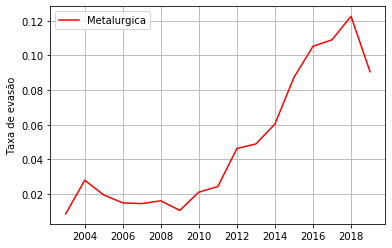

In [184]:
import matplotlib.pyplot as plt
plt.plot(MET.iloc[:,2].values, MET.iloc[:,5].values, color = 'red', label = 'Metalurgica')
plt.ylabel('Taxa de evasão')
plt.grid(True)
plt.legend(loc = ('best'))
plt.show()

In [173]:
Evasao_cursos_ano

NameError: name 'Evasao_cursos_ano' is not defined